<a href="https://colab.research.google.com/github/changdaeoh/HandsOn_DL/blob/master/sub_materials/3_CNNs_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR 10

### data load

In [1]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


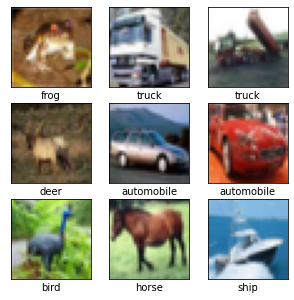

In [2]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(777)

class_names = ['airplane', 'automobile', 'bird', 'cat',
              'deer', 'dog', 'frog', 'horse',
              'ship', 'truck']

sample_size = 9
random_idx = np.random.randint(60000, size=sample_size) 

plt.figure(figsize = (5, 5))
for i, idx in enumerate(random_idx):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], cmap = 'gray')
    plt.xlabel(class_names[int(y_train[i])])
plt.show()

### preprocessing

In [3]:
# axis = (0, 1, 2)의 의미 : 배치, weight, height를 전부 통합하여 mean을 취하겠다는 것.
# input : (bs, W, H, C), ouput : ( C ) 가 됨.
x_mean = np.mean(x_train, axis = (0, 1, 2))
x_std = np.std(x_train, axis = (0, 1, 2))

x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size = 0.3)

print(x_train.shape, len(y_train))
print(x_val.shape, len(y_val))

(35000, 32, 32, 3) 35000
(15000, 32, 32, 3) 15000


### Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(32, 3, padding = 'same', activation = 'relu', input_shape = (32, 32, 3)))
model.add(Conv2D(32, 3, padding = 'same', activation = 'relu'))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(64, 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(64, 3, padding = 'same', activation = 'relu'))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(128, 3, padding = 'same', activation = 'relu'))
model.add(MaxPool2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(10, activation = 'softmax')) # 10개의 출력을 가지는 신경망

model.compile(optimizer = Adam(1e-4),
             loss = 'sparse_categorical_crossentropy', # 원핫인코딩 안하고 0 ~ 9 레이블 그대로 사용
             metrics = ['acc'])

In [ ]:
history = model.fit(x_train, y_train,
                    epochs = 30,
                    batch_size = 128,
                    validation_data = (x_val, y_val),
                    verbose = 0)

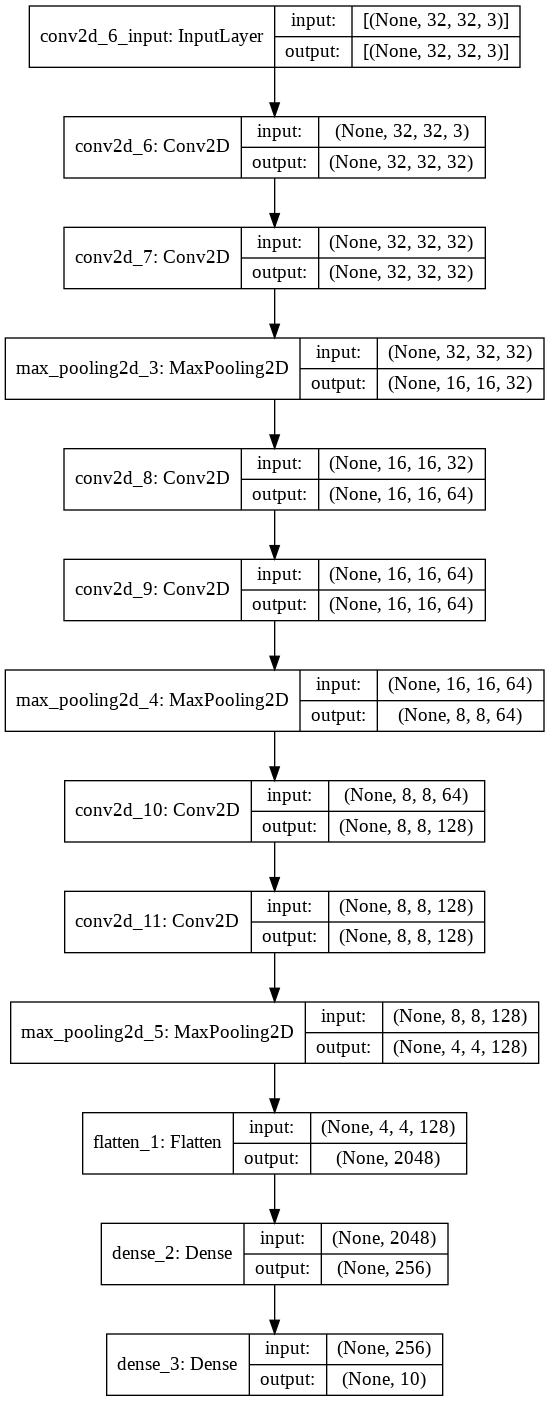

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, './cnn_cifar10.png', show_shapes=True)

In [4]:
import matplotlib.pyplot as plt

def learning_curve(history):
    hist = history.history
    train_acc, val_acc, train_loss, val_loss =\
        hist["acc"], hist["val_acc"], hist["loss"], hist["val_loss"]

    fig = plt.figure(figsize = (12, 6))
    plt.style.use("seaborn-dark")

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(range(len(train_acc)), train_acc, label = "train_acc")
    ax2.plot(range(len(train_acc)), val_acc, label = "val_acc")
    ax1.plot(range(len(train_acc)), train_loss, label = "train_loss")
    ax1.plot(range(len(train_acc)), val_loss, label = "val_loss")

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Acc')

    plt.legend()
    plt.tight_layout()
    plt.show()

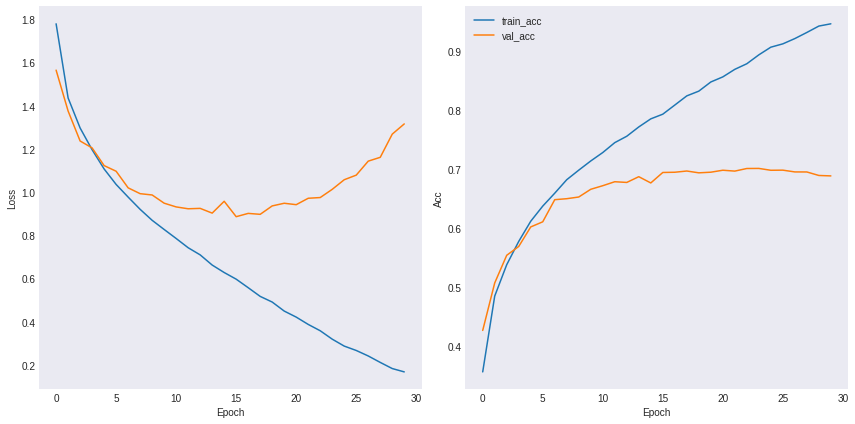

313/313 [==============================] - 1s 2ms/step - loss: 1.3390 - acc: 0.6884
test acc : 0.6883999705314636


In [ ]:
learning_curve(history)
print(f'test acc : {model.evaluate(x_test, y_test)[1]}')

### CNN 시각화

In [ ]:
import tensorflow as tf

get_layer_name = [layer.name for layer in model.layers]
get_output = [layer.output for layer in model.layers]

# 모델 전체에서 output을 받아내기위해 함수형 API로 새로운 모델 정의
# INPUT은 위의 모델과 동일한데 각 층마다 OUTPUT(feature map)을 내보냄
visual_model = tf.keras.models.Model(inputs = model.input, outputs = get_output)

test_img = np.expand_dims(x_test[1], axis = 0)
feature_maps = visual_model(test_img)  # same with 'visual_model.predict(test_img)'
# 이미지를 흘려보내면 output이 층의 개수만큼 나옴

In [ ]:
for i in range(12):
    print(feature_maps[i].shape)

(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 16, 16, 32)
(1, 16, 16, 64)
(1, 16, 16, 64)
(1, 8, 8, 64)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 4, 4, 128)
(1, 2048)
(1, 256)
(1, 10)


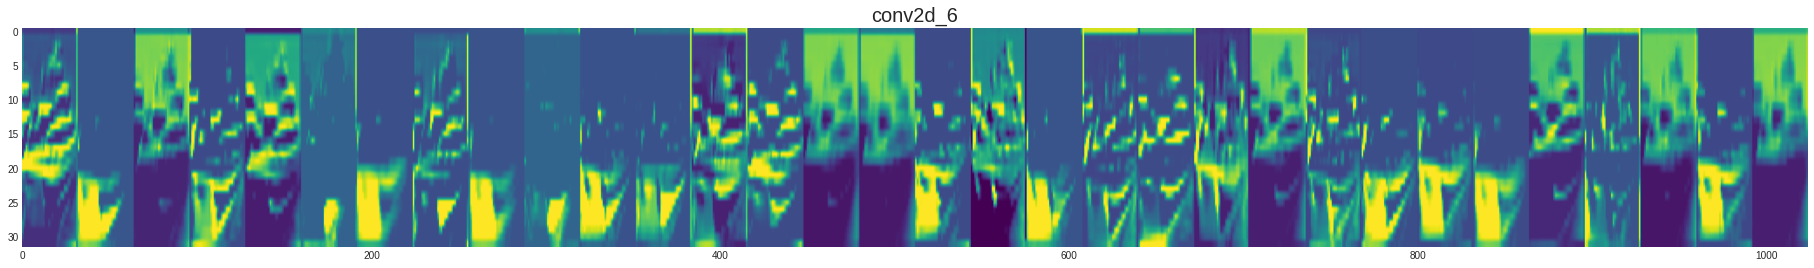

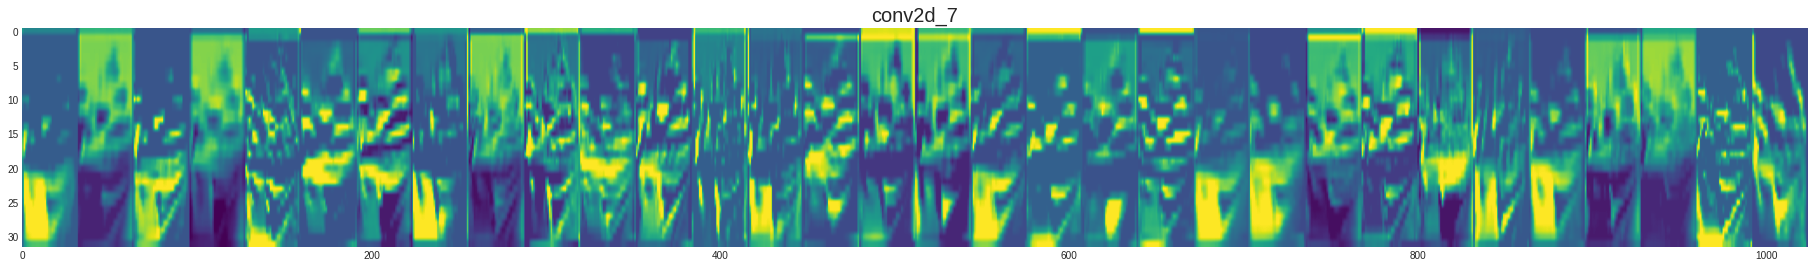

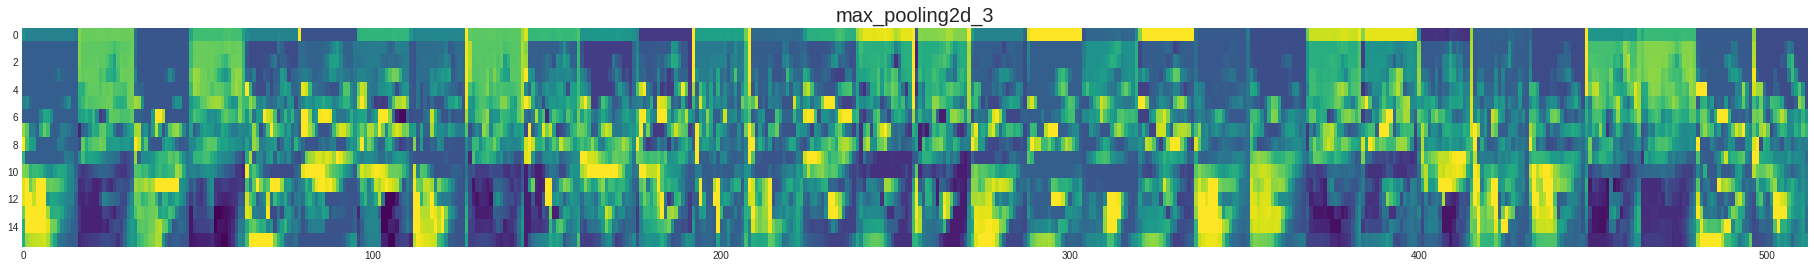

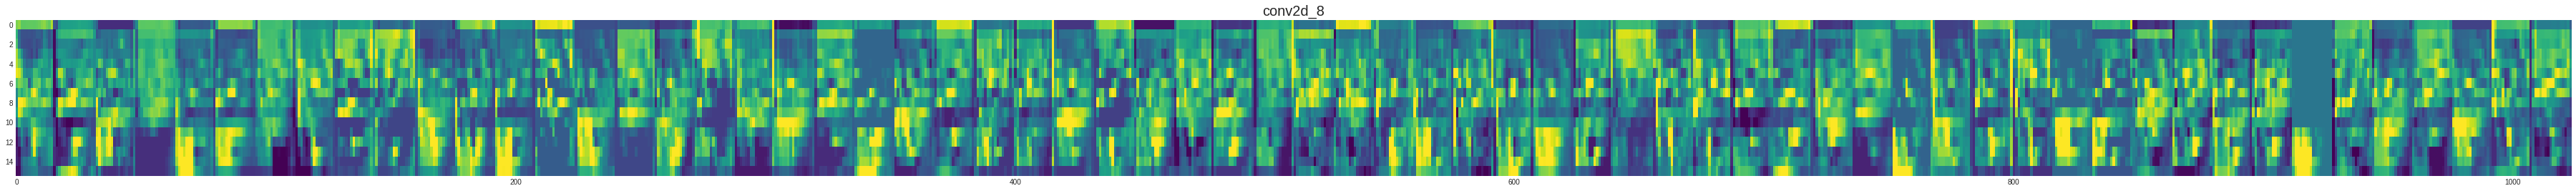

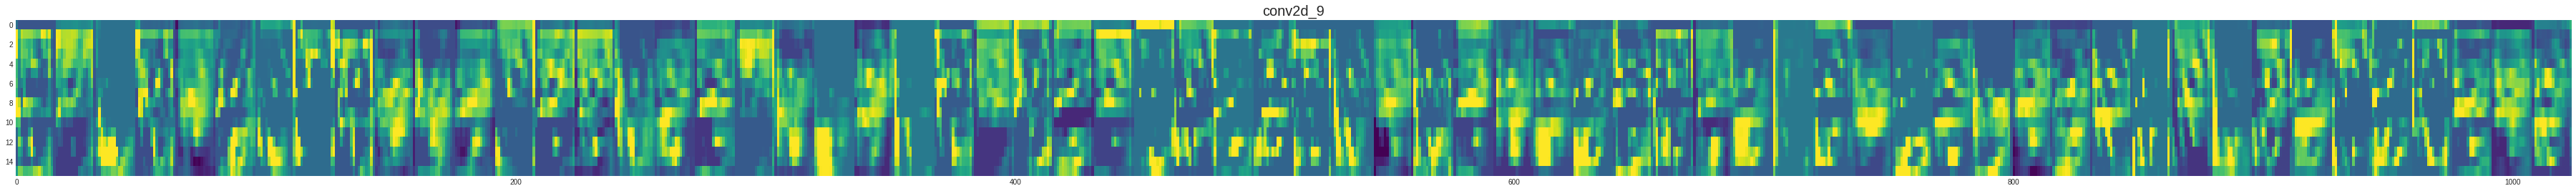

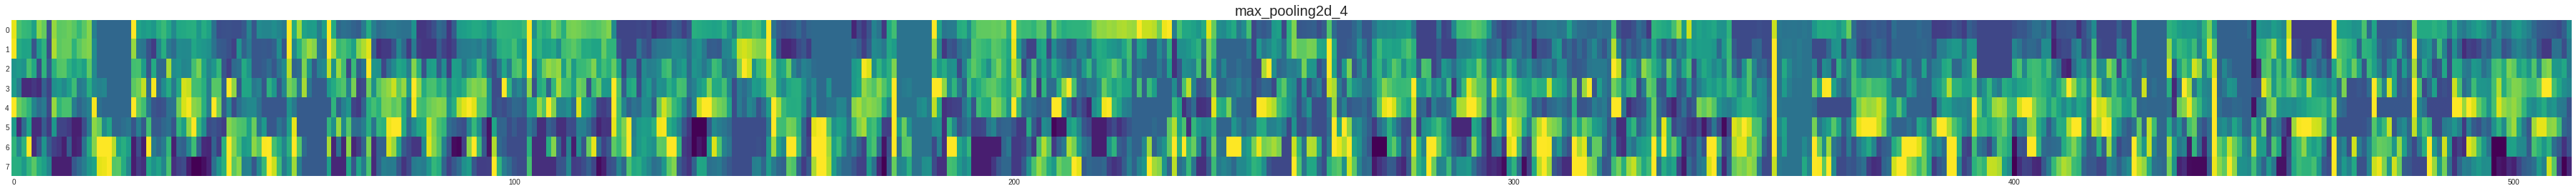

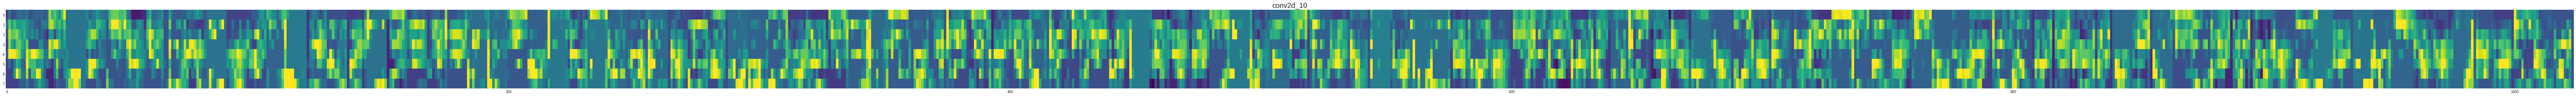

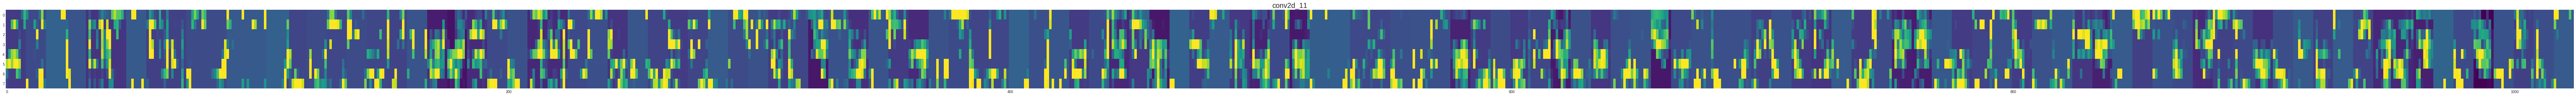

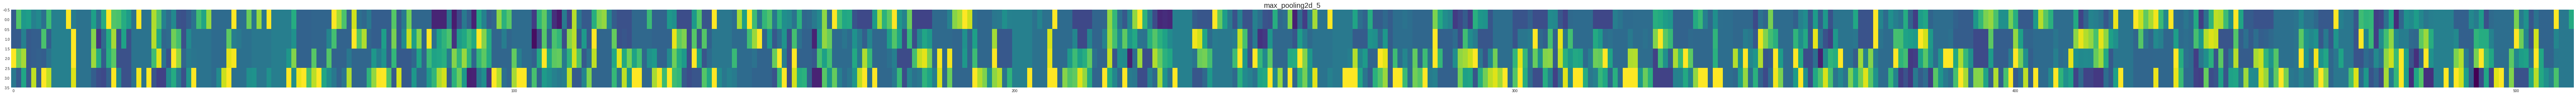

In [ ]:
for layer_name, feature_map in zip(get_layer_name, feature_maps):
    # Dense 층은 제외
    if(len(feature_map.shape) == 4):
        img_size = feature_map.shape[1]    # 이미지 사이즈
        channels = feature_map.shape[-1]   # 채널 수 
        
        # (img_size, img_size)의 feature_map이 channels 개수만큼 존재.
        display_grid = np.zeros((img_size, img_size * channels))
        
        # 각 feature map을 display_grid 배열에 이어붙임.
        for i in range(channels):
            x = feature_map[0, :, :, i]
            x -= x.mean(); x /= x.std()                               # 픽셀 정규화
            x *= 64; x += 128                                         # 적당히 잘보이게 조절
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * img_size : (i + 1) * img_size] = x
            
        plt.figure(figsize = (channels, 4 + 1./channels))
        plt.title(layer_name, fontsize = 20)
        plt.grid(False)
        plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

# overfitting 해소를 위한 방법들
* weight decay
* dropout
* bn

In [8]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Activation
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1, l1_l2

In [9]:
model_l1 = Sequential([
                    Conv2D(32, 3, padding = "same", activation = "relu", input_shape = (32, 32, 3)),
                    Conv2D(32, 3, padding = "same", activation = "relu", kernel_regularizer=l1(0.0005)),
                    MaxPool2D((2,2), 2),

                    Conv2D(64, 3, padding = "same", activation = "relu"),
                    Conv2D(64, 3, padding = "same", activation = "relu", kernel_regularizer=l1(0.0005)),
                    MaxPool2D((2,2), 2),

                    Conv2D(128, 3, padding = "same", activation = "relu"),
                    Conv2D(128, 3, padding = "same", activation = "relu", kernel_regularizer=l1(0.0005)),
                    MaxPool2D((2,2), 2),

                    Flatten(),
                    Dense(512, activation = "relu", kernel_regularizer=l1(0.0005)),
                    Dense(256, activation = "relu"),
                    Dense(10, activation = "softmax")
])

model_l1.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                 metrics = ['acc'])

In [10]:
model_l2 = Sequential([
                    Conv2D(32, 3, padding = "same", activation = "relu", input_shape = (32, 32, 3)),
                    Conv2D(32, 3, padding = "same", activation = "relu", kernel_regularizer=l2(0.0005)),
                    MaxPool2D((2,2), 2),

                    Conv2D(64, 3, padding = "same", activation = "relu"),
                    Conv2D(64, 3, padding = "same", activation = "relu", kernel_regularizer=l2(0.0005)),
                    MaxPool2D((2,2), 2),

                    Conv2D(128, 3, padding = "same", activation = "relu"),
                    Conv2D(128, 3, padding = "same", activation = "relu", kernel_regularizer=l2(0.0005)),
                    MaxPool2D((2,2), 2),

                    Flatten(),
                    Dense(512, activation = "relu", kernel_regularizer=l2(0.0005)),
                    Dense(256, activation = "relu"),
                    Dense(10, activation = "softmax")
])
model_l2.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                 metrics = ['acc'])

In [11]:
model_ela = Sequential([
                    Conv2D(32, 3, padding = "same", activation = "relu", input_shape = (32, 32, 3)),
                    Conv2D(32, 3, padding = "same", activation = "relu", 
                           kernel_regularizer=l1_l2(0.0001, 0.0005)),
                    MaxPool2D((2,2), 2),

                    Conv2D(64, 3, padding = "same", activation = "relu"),
                    Conv2D(64, 3, padding = "same", activation = "relu", 
                           kernel_regularizer=l1_l2(0.0001, 0.0005)),
                    MaxPool2D((2,2), 2),

                    Conv2D(128, 3, padding = "same", activation = "relu"),
                    Conv2D(128, 3, padding = "same", activation = "relu",
                           kernel_regularizer=l1_l2(0.0001, 0.0005)),
                    MaxPool2D((2,2), 2),

                    Flatten(),
                    Dense(512, activation = "relu", kernel_regularizer=l1_l2(0.0001, 0.0005)),
                    Dense(256, activation = "relu"),
                    Dense(10, activation = "softmax")
])
model_ela.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                 metrics = ['acc'])

In [12]:
model_do = Sequential([
                    Conv2D(32, 3, padding = "same", activation = "relu", input_shape = (32, 32, 3)),
                    Conv2D(32, 3, padding = "same", activation = "relu"),
                    MaxPool2D((2,2), 2),
                    Dropout(0.2),

                    Conv2D(64, 3, padding = "same", activation = "relu"),
                    Conv2D(64, 3, padding = "same", activation = "relu"),
                    MaxPool2D((2,2), 2),
                    Dropout(0.2),

                    Conv2D(128, 3, padding = "same", activation = "relu"),
                    Conv2D(128, 3, padding = "same", activation = "relu"),
                    MaxPool2D((2,2), 2),
                    Dropout(0.2),

                    Flatten(),
                    Dense(512, activation = "relu"),
                    Dropout(0.2),
                    Dense(256, activation = "relu"),
                    Dense(10, activation = "softmax")
])
model_do.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                 metrics = ['acc'])

In [13]:
model_do = Sequential([
                    Conv2D(32, 3, padding = "same", activation = "relu", input_shape = (32, 32, 3)),
                    Conv2D(32, 3, padding = "same", activation = "relu"),
                    MaxPool2D((2,2), 2),
                    Dropout(0.2),

                    Conv2D(64, 3, padding = "same", activation = "relu"),
                    Conv2D(64, 3, padding = "same", activation = "relu"),
                    MaxPool2D((2,2), 2),
                    Dropout(0.2),

                    Conv2D(128, 3, padding = "same", activation = "relu"),
                    Conv2D(128, 3, padding = "same", activation = "relu"),
                    MaxPool2D((2,2), 2),
                    Dropout(0.2),

                    Flatten(),
                    Dense(512, activation = "relu"),
                    Dropout(0.2),
                    Dense(256, activation = "relu"),
                    Dense(10, activation = "softmax")
])
model_do.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                 metrics = ['acc'])

In [14]:
model_bn = Sequential([
                    Conv2D(32, 3, padding = "same", input_shape = (32, 32, 3)),
                    BatchNormalization(),
                    Activation("relu"),
                    Conv2D(32, 3, padding = "same", use_bias = False),
                    BatchNormalization(),
                    Activation("relu"),
                    MaxPool2D((2,2), 2),
                    
                    Conv2D(64, 3, padding = "same", use_bias = False),
                    BatchNormalization(),
                    Activation("relu"),
                    Conv2D(64, 3, padding = "same", use_bias = False),
                    BatchNormalization(),
                    Activation("relu"),
                    MaxPool2D((2,2), 2),
                    
                    Conv2D(128, 3, padding = "same", use_bias = False),
                    BatchNormalization(),
                    Activation("relu"),
                    Conv2D(128, 3, padding = "same", use_bias = False),
                    BatchNormalization(),
                    Activation("relu"),
                    MaxPool2D((2,2), 2),

                    Flatten(),
                    Dense(512),
                    BatchNormalization(),
                    Activation("relu"),
                    Dense(256, use_bias = False),
                    BatchNormalization(),
                    Activation("relu"),
                    Dense(10, activation = "softmax")
])
model_bn.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                 metrics = ['acc'])

In [15]:
history1 = model_l1.fit(x_train, y_train, epochs = 30, 
                        validation_data = (x_val, y_val),
                        verbose = 0)
history2 = model_l2.fit(x_train, y_train, epochs = 30, 
                        validation_data = (x_val, y_val),
                        verbose = 0)
history3 = model_ela.fit(x_train, y_train, epochs = 30, 
                        validation_data = (x_val, y_val),
                        verbose = 0)
history4 = model_do.fit(x_train, y_train, epochs = 30, 
                        validation_data = (x_val, y_val),
                        verbose = 0)
history5 = model_bn.fit(x_train, y_train, epochs = 30, 
                        validation_data = (x_val, y_val),
                        verbose = 0)

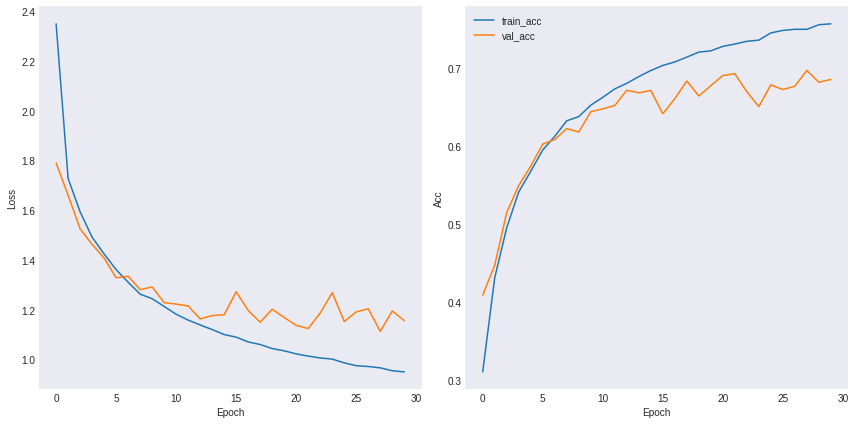

313/313 [==============================] - 1s 3ms/step - loss: 1.1693 - acc: 0.6852
test acc : 0.6851999759674072


In [16]:
learning_curve(history1)
print(f'test acc : {model_l1.evaluate(x_test, y_test)[1]}')

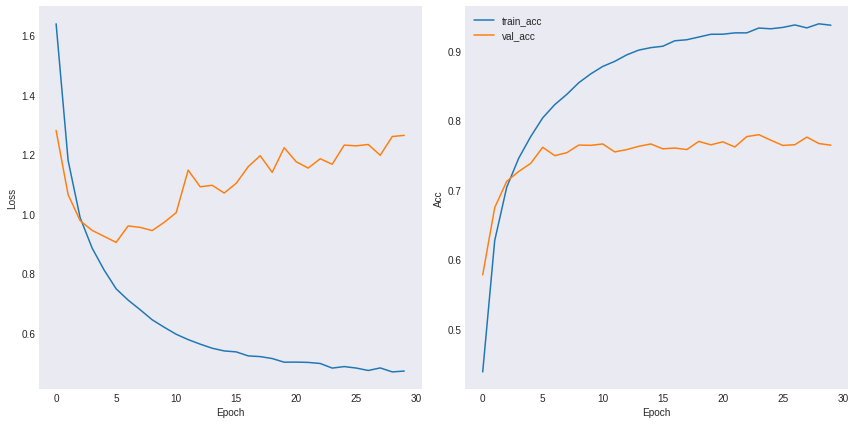

313/313 [==============================] - 1s 3ms/step - loss: 1.3247 - acc: 0.7541
test acc : 0.7541000247001648


In [17]:
learning_curve(history2)
print(f'test acc : {model_l2.evaluate(x_test, y_test)[1]}')

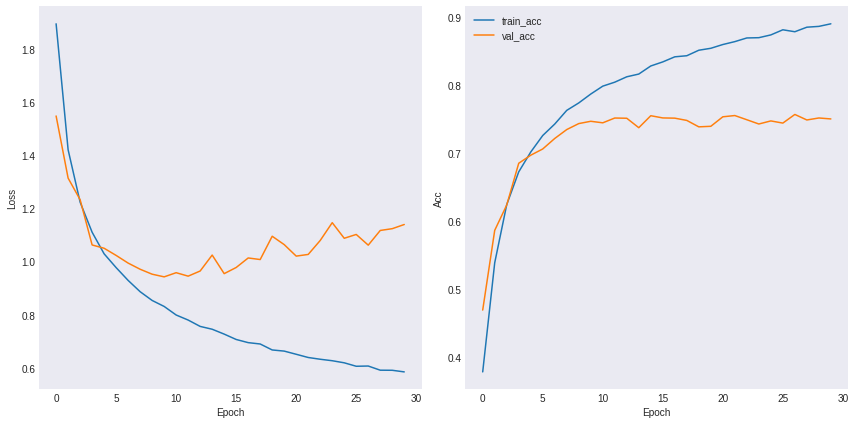

313/313 [==============================] - 1s 3ms/step - loss: 1.1565 - acc: 0.7529
test acc : 0.7529000043869019


In [18]:
learning_curve(history3)
print(f'test acc : {model_ela.evaluate(x_test, y_test)[1]}')

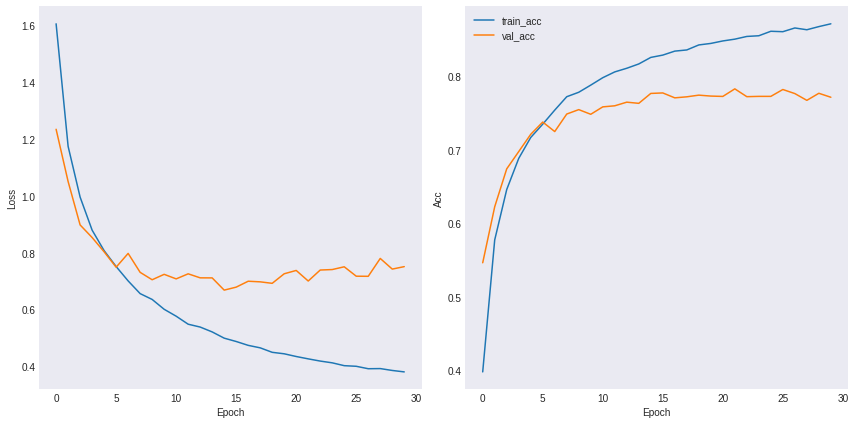

313/313 [==============================] - 1s 3ms/step - loss: 0.7691 - acc: 0.7680
test acc : 0.7680000066757202


In [19]:
learning_curve(history4)
print(f'test acc : {model_do.evaluate(x_test, y_test)[1]}')

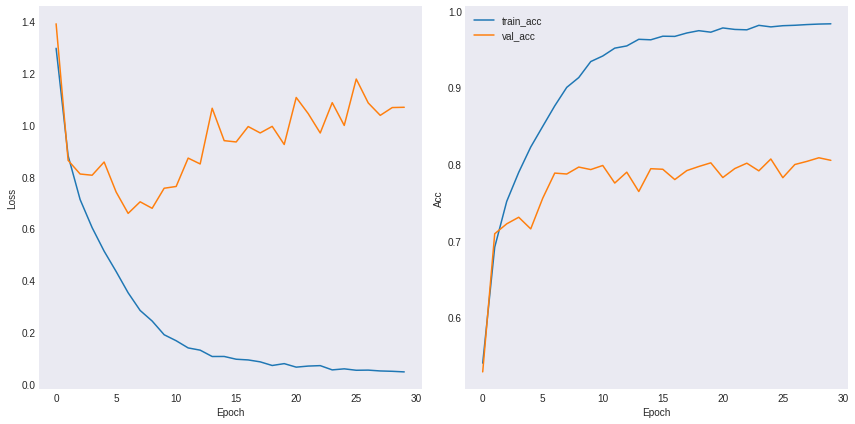

313/313 [==============================] - 1s 3ms/step - loss: 1.1132 - acc: 0.7961
test acc : 0.7961000204086304


In [20]:
learning_curve(history5)
print(f'test acc : {model_bn.evaluate(x_test, y_test)[1]}')

# Fully Convolutional Network Experiment
* fc layer들을 conv layer로 대체했을 때 성능차이는?
* 파라미터수는 완전히 동일
* flatten하는 대신 full size kernel convolving을 통해 공간정보를 끝까지 이용하므로 성능이 더 나은걸까?

In [32]:
model_fcn = Sequential([
                    Conv2D(32, 3, padding = "same", input_shape = (32, 32, 3)),
                    BatchNormalization(),
                    Activation("relu"),
                    Conv2D(32, 3, padding = "same", use_bias = False),
                    BatchNormalization(),
                    Activation("relu"),
                    MaxPool2D((2,2), 2),
                    
                    Conv2D(64, 3, padding = "same", use_bias = False),
                    BatchNormalization(),
                    Activation("relu"),
                    Conv2D(64, 3, padding = "same", use_bias = False),
                    BatchNormalization(),
                    Activation("relu"),
                    MaxPool2D((2,2), 2),
                    
                    Conv2D(128, 3, padding = "same", use_bias = False),
                    BatchNormalization(),
                    Activation("relu"),
                    Conv2D(128, 3, padding = "same", use_bias = False),
                    BatchNormalization(),
                    Activation("relu"),
                    MaxPool2D((2,2), 2),

                    Conv2D(512, kernel_size=(4, 4), strides=(1,1), padding = "valid"),
                    BatchNormalization(),
                    Activation("relu"),
                    Conv2D(256, 1, padding = "valid", use_bias = False),
                    BatchNormalization(),
                    Activation("relu"),
                    Conv2D(10, 1, padding = "valid", activation = "softmax"),
                    Flatten()
])
model_fcn.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                 metrics = ['acc'])

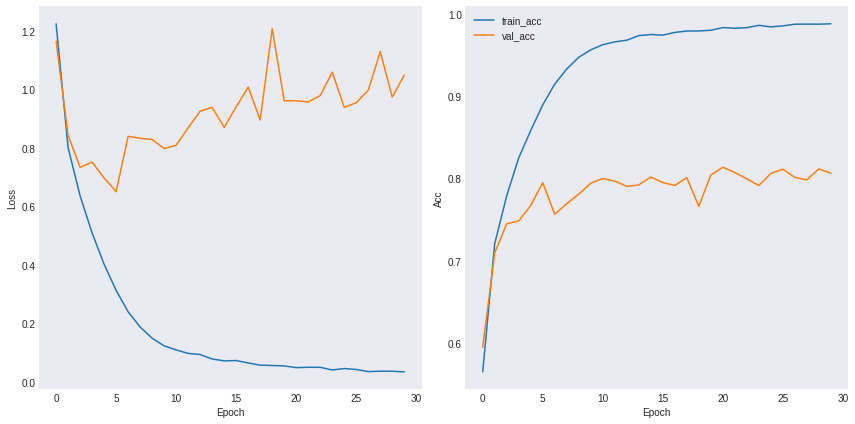

313/313 [==============================] - 1s 3ms/step - loss: 1.1006 - acc: 0.7994
test acc : 0.7993999719619751


In [34]:
history6 = model_fcn.fit(x_train, y_train, epochs = 30, 
                        validation_data = (x_val, y_val),
                        verbose = 0)

learning_curve(history6)
print(f'test acc : {model_fcn.evaluate(x_test, y_test)[1]}')

In [38]:
model2 = Sequential([
                    Conv2D(32, 3, padding = "same", activation = "relu", input_shape = (32, 32, 3)),
                    MaxPool2D((2,2), 2),

                    Conv2D(64, 3, padding = "same", activation = "relu"),
                    MaxPool2D((2,2), 2),

                    Conv2D(128, 3, padding = "same", activation = "relu"),
                    MaxPool2D((2,2), 2),

                    Flatten(),
                    Dense(512, activation = "relu"),
                    Dense(256, activation = "relu"),
                    Dense(10, activation = "softmax")
])


model_fcn2 = Sequential([
                    Conv2D(32, 3, padding = "same", activation = "relu", input_shape = (32, 32, 3)),
                    MaxPool2D((2,2), 2),

                    Conv2D(64, 3, padding = "same", activation = "relu"),
                    MaxPool2D((2,2), 2),

                    Conv2D(128, 3, padding = "same", activation = "relu"),
                    MaxPool2D((2,2), 2),

                    Conv2D(512, kernel_size=(4, 4), strides=(1,1), padding = "valid", activation = "relu"),
                    Conv2D(256, 1, padding = "valid", activation = "relu"),
                    Conv2D(10, 1, padding = "valid", activation = "softmax"),
                    Flatten()
])

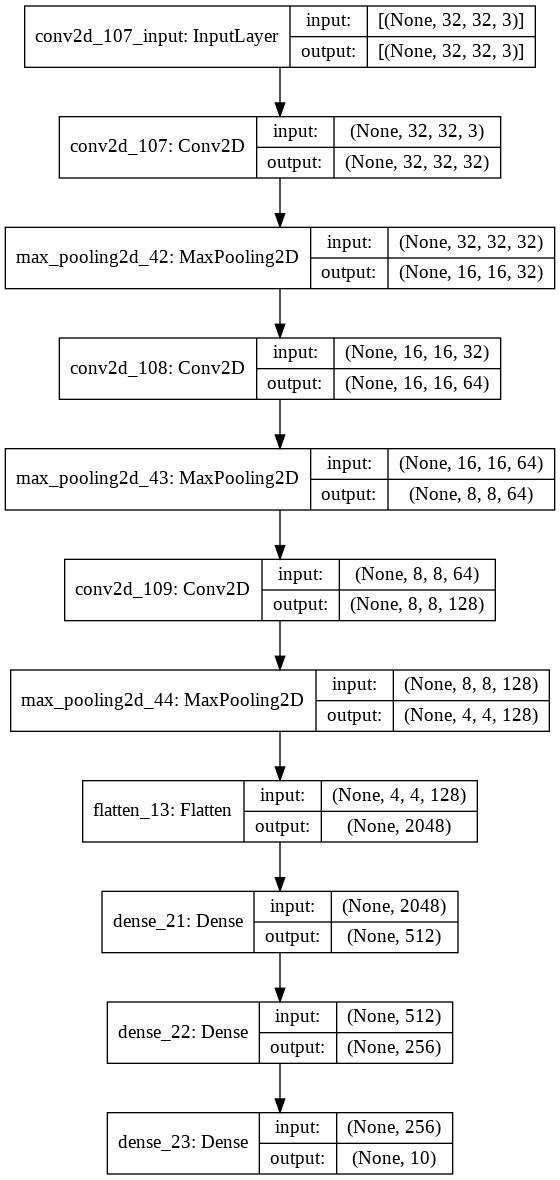

In [39]:
plot_model(model2, './sample1.png', show_shapes=True)

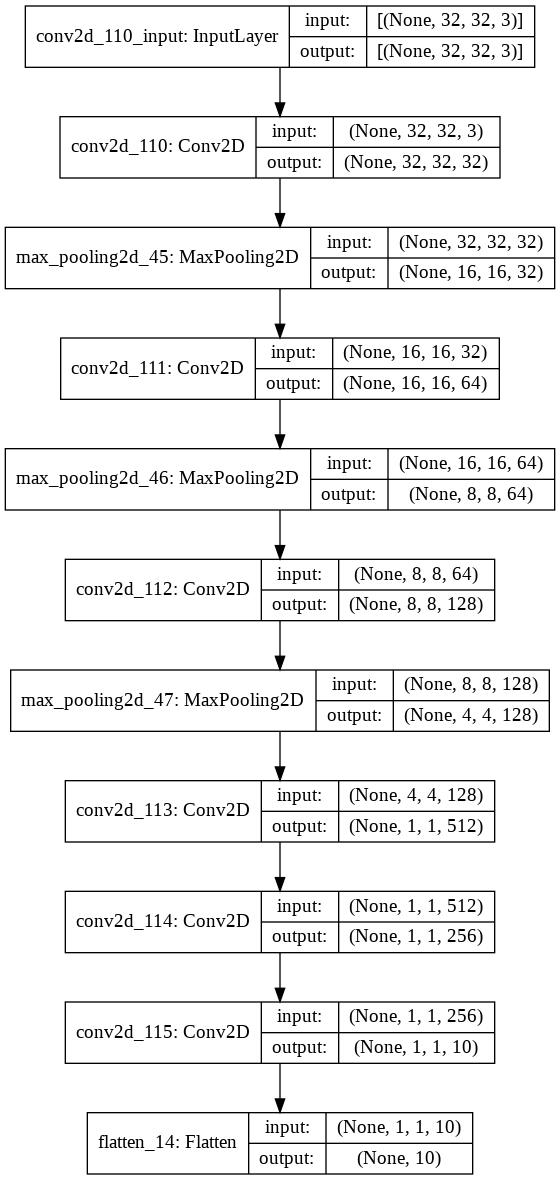

In [40]:
plot_model(model_fcn2, './sample1.png', show_shapes=True)